---
title: GSB - S544 Lab 4
author: Karissa Mohr
format:
  html:
    embed-resources: true
echo: true
theme: lux
---

# Lab 4: Data is Delicious

1. Data from unstructured websites

Scrape the weekly meal plan into a table with the following columns:

*   Day of the Week
*   Name of Recipe
*   Link to Recipe
*   Price of Recipe

In [112]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

In [113]:
# get html
url = "https://tastesbetterfromscratch.com/meal-plan-207/"
headers = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/122.0 Safari/537.36"
    )
}

response = requests.get(url, headers=headers)
response.raise_for_status()

In [114]:
# parse html
soup = BeautifulSoup(response.content, "html.parser")
article = soup.find("article")
paragraphs = article.find_all("p")

In [115]:
# results
results = []
for p in paragraphs:
    strong = p.find("strong")
    if not strong:
        continue
    day = strong.get_text(strip=True).capitalize()
    a_tag = p.find("a", href=True)
    if not a_tag:
        continue
    recipe_name = a_tag.get_text(strip=True)
    recipe_link = a_tag["href"]
    text = p.get_text(" ", strip=True)
    price_match = re.search(r"\$\s?\d+(?:\.\d{1,2})?", text)
    price = price_match.group(0) if price_match else ""
    results.append({
        "Day of Week": day,
        "Name of Recipe": recipe_name,
        "Link to Recipe": recipe_link,
        "Price": price
    })

In [117]:
mealplan_207 = pd.DataFrame(results)
mealplan_207

,Day of Week,Name of Recipe,Link to Recipe,Price
0,Monday,Salmon Tacos,https://tastesbetterfromscratch.com/salmon-tacos/,$25.79
1,Tuesday,Mediterranean Meatball Bowl,https://tastesbetterfromscratch.com/mediterran...,$14.24
2,Wednesday:,Boursin Pasta,https://tastesbetterfromscratch.com/boursin-pa...,$13
3,Thursday:,Cevapi,https://tastesbetterfromscratch.com/cevapi/,$31
4,Friday:,Panang Curry,https://tastesbetterfromscratch.com/panang-curry/,$21.82



2. Data from an API



Using the Tasty API from the practice activity, search for recipes that match the “Monday” recipe in your meal plan. Compile a table of all these recipes.

In [118]:
monday_recipe = mealplan_207.loc[
    mealplan_207["Day of Week"].str.lower() == "monday", "Name of Recipe"
].iloc[0]
print("Monday recipe:", monday_recipe)

Monday recipe: Salmon Tacos


In [119]:
search_term = (
    re.sub(r"\(.*?\)", "", monday_recipe)
    .replace("&", "and")
    .replace("-", " ")
    .lower()
    .strip()
)
print("Search term for API:", search_term)

Search term for API: salmon tacos


In [120]:
url = "https://tasty.p.rapidapi.com/recipes/list"
headers = {
    "X-RapidAPI-Key": "e94d685116msh430ee357ea57972p172878jsnfb83db3a5177",
    "X-RapidAPI-Host": "tasty.p.rapidapi.com"
}

In [122]:
all_results = []

for start in range(0, 100, 20):
    querystring = {"from": str(start), "size": "20", "q": search_term}
    response = requests.get(url, headers=headers, params=querystring)
    if response.status_code != 200:
        print(f"Request failed (page {start}):", response.status_code)
        break

    data = response.json()
    if "results" not in data or not data["results"]:
        break

    df_chunk = pd.json_normalize(data["results"])
    if df_chunk.empty:
        break

    all_results.append(df_chunk)
    time.sleep(0.5)

if all_results:
    monday_tasty_recipes = pd.concat(all_results, ignore_index=True)
else:
    monday_tasty_recipes = pd.DataFrame()

keep_cols = [
    "id", "name", "description", "num_servings",
    "nutrition.calories", "nutrition.protein",
    "nutrition.carbohydrates", "nutrition.fat", "nutrition.sugar"
]
keep_cols = [c for c in keep_cols if c in monday_tasty_recipes.columns]
monday_tasty_recipes = monday_tasty_recipes[keep_cols].copy()

monday_tasty_recipes = monday_tasty_recipes.rename(columns={
    "name": "Tasty Recipe",
    "nutrition.calories": "Calories",
    "nutrition.protein": "Protein",
    "nutrition.carbohydrates": "Carbs",
    "nutrition.fat": "Fat",
    "nutrition.sugar": "Sugar"
})

monday_tasty_recipes.head()

,id,Tasty Recipe,description,num_servings,Calories,Protein,Carbs,Fat,Sugar
0,5507,Spice-Rubbed Shrimp Tacos,Experience a fiesta of flavors with these Spic...,8.0,233.0,15.0,25.0,7.0,1.0
1,7121,Mango Salsa Fish Tacos,,4.0,514.0,29.0,34.0,28.0,7.0
2,1578,Fish Lovers Only,When in doubt for dinner? Make fish! Recipes l...,NaN,NaN,NaN,NaN,NaN,NaN
3,989,12 Delicious Seafood Dinners,None,NaN,NaN,NaN,NaN,NaN,NaN


3. Automate it



Write a function called get_mealplan_data that performs 2 and 3 above automatically. That is, your function should:

Take as input a number 100-210, representing which weekly meal plan you are referencing.

Scrape the meal plan from the meal planning site.

Query the Tasty API for recipes matching each of the ones in the chosen weekly meal plan.

Output a single dataset, which contains all the information from the above

Hint: You may have an easier time if you write two smaller functions, get_weekly_plan and match_recipe, and then you use them inside your main function.

Run the following code, which should work if your function is complete:

df = get_mealplan_data(202)


In [64]:
def get_weekly_plan(plan_number):
    """
    Scrape a weekly meal plan from tastesbetterfromscratch.com
    Returns: DataFrame with Day, Recipe, Link, and Price.
    """
    url = f"https://tastesbetterfromscratch.com/meal-plan-{plan_number}/"
    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0 Safari/537.36"
        )
    }

    resp = requests.get(url, headers=headers)
    resp.raise_for_status()
    soup = BeautifulSoup(resp.content, "html.parser")

    article = soup.find("article")
    paragraphs = article.find_all(["p", "li"])

    rows = []
    for p in paragraphs:
        strong = p.find("strong")
        if not strong:
            continue
        day = strong.get_text(strip=True).capitalize()
        a_tag = p.find("a", href=True)
        if not a_tag:
            continue
        name = a_tag.get_text(strip=True)
        link = a_tag["href"]
        text = p.get_text(" ", strip=True)
        m = re.search(r"\$\s?\d+(?:\.\d{1,2})?", text)
        price = m.group(0) if m else ""
        rows.append({
            "Day of the Week": day,
            "Name of Recipe": name,
            "Link to Recipe": link,
            "Price of Recipe": price
        })
    return pd.DataFrame(rows)

In [123]:
plan_202 = get_weekly_plan(202)
plan_202

,Day of the Week,Name of Recipe,Link to Recipe,Price of Recipe
0,Monday,Chicken Divan,https://tastesbetterfromscratch.com/skinny-chi...,$10.82
1,Tuesday,Beef Noodle Soup,https://tastesbetterfromscratch.com/beef-noodl...,$29.29
2,Wednesday:,Stuffed Shells,https://tastesbetterfromscratch.com/lasagna-st...,$12.30
3,Thursday:,Vegetarian Stuffed Peppers,https://tastesbetterfromscratch.com/southwest-...,$19.60
4,Friday:,Chicken Gyros,https://tastesbetterfromscratch.com/chicken-gy...,$21.22


In [131]:
def match_recipe(recipe_name):
    """
    Search the Tasty API for a given recipe name and return matching recipes
    with nutrition information.
    """

    search_term = (
        re.sub(r"\(.*?\)", "", recipe_name)
        .replace("&", "and")
        .replace("-", " ")
        .lower()
        .strip()
    )

    url = "https://tasty.p.rapidapi.com/recipes/list"
    headers = {
        "X-RapidAPI-Key": "e94d685116msh430ee357ea57972p172878jsnfb83db3a5177",
        "X-RapidAPI-Host": "tasty.p.rapidapi.com"
    }

    all_chunks = []
    for start in range(0, 100, 20):
        params = {"from": str(start), "size": "20", "q": search_term}
        r = requests.get(url, headers=headers, params=params)
        if r.status_code != 200:
            print(f"API {r.status_code} for {recipe_name}")
            break

        data = r.json()
        if "results" not in data or not data["results"]:
            break

        chunk = pd.json_normalize(data["results"])
        all_chunks.append(chunk)
        time.sleep(0.5)

    if not all_chunks:
        return pd.DataFrame()

    df = pd.concat(all_chunks, ignore_index=True)

    keep_cols = [
        "name", "num_servings",
        "nutrition.calories", "nutrition.protein",
        "nutrition.carbohydrates", "nutrition.fat", "nutrition.sugar"
    ]
    keep_cols = [c for c in keep_cols if c in df.columns]
    df = df[keep_cols].copy()
    df = df.rename(columns={
        "name": "Tasty Recipe",
        "nutrition.calories": "Calories",
        "nutrition.protein": "Protein",
        "nutrition.carbohydrates": "Carbs",
        "nutrition.fat": "Fat",
        "nutrition.sugar": "Sugar"
    })

    return df


In [125]:
test_df = match_recipe("Chicken Divan")
test_df.head()

No results for Chicken Divan


""


In [126]:
match_recipe("chicken")

,Tasty Recipe,num_servings,Calories,Protein,Carbs,Fat,Sugar
0,Low-Carb Avocado Chicken Salad,4,249.0,29.0,13.0,8.0,8.0
1,Creamy Cajun Pasta,8,395.0,18.0,31.0,24.0,6.0
2,Creamy Tuscan Chicken,4,618.0,39.0,8.0,53.0,5.0
3,100-Layer Lasagna,20,747.0,52.0,46.0,32.0,15.0
4,Original Orange Chicken by Panda Express,8,900.0,33.0,65.0,56.0,9.0
...,...,...,...,...,...,...,...
95,BBQ Chicken Pasta Bake,8,585.0,29.0,49.0,31.0,17.0
96,Homemade Butter Chicken,4,NaN,NaN,NaN,NaN,NaN
97,Baked Chicken Parmesan,2,666.0,72.0,26.0,29.0,4.0
98,Honey BBQ Chicken Wings,20,166.0,8.0,16.0,7.0,9.0


In [132]:
# combine functions
def get_mealplan_data(plan_number):
    """
    1. Scrape the meal plan for plan number
    2. Query the Tasty API for each recipe
    3. Return combined DataFrame with nutrition info
    """
    plan_df = get_weekly_plan(plan_number)
    if plan_df.empty:
        print(f"No meal plan found for {plan_number}.")
        return pd.DataFrame()

    all_results = []

    for _, row in plan_df.iterrows():
        recipe_name = row["Name of Recipe"]

        df_api = match_recipe(recipe_name)

        if df_api.empty:
            keyword = recipe_name.split()[0]
            df_api = match_recipe(keyword)

        if df_api.empty:
            continue

        df_api.insert(0, "Day of the Week", row["Day of the Week"])
        df_api.insert(1, "Meal Plan Recipe", recipe_name)
        df_api.insert(2, "Link to Recipe", row["Link to Recipe"])
        df_api.insert(3, "Price of Recipe", row["Price of Recipe"])

        all_results.append(df_api)

    if not all_results:
        print("No API results found.")
        return pd.DataFrame()

    df = pd.concat(all_results, ignore_index=True)
    print(f"Compiled {len(df)} total API results for Meal Plan {plan_number}.")
    return df

In [133]:
df = get_mealplan_data(202)
df

/tmp/ipython-input-457698959.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Compiled 221 total API results for Meal Plan 202.


,Day of the Week,Meal Plan Recipe,Link to Recipe,Price of Recipe,Tasty Recipe,num_servings,Calories,Protein,Carbs,Fat,Sugar
0,Monday,Chicken Divan,https://tastesbetterfromscratch.com/skinny-chi...,$10.82,Low-Carb Avocado Chicken Salad,4.0,249.0,29.0,13.0,8.0,8.0
1,Monday,Chicken Divan,https://tastesbetterfromscratch.com/skinny-chi...,$10.82,Creamy Cajun Pasta,8.0,395.0,18.0,31.0,24.0,6.0
2,Monday,Chicken Divan,https://tastesbetterfromscratch.com/skinny-chi...,$10.82,Creamy Tuscan Chicken,4.0,618.0,39.0,8.0,53.0,5.0
3,Monday,Chicken Divan,https://tastesbetterfromscratch.com/skinny-chi...,$10.82,100-Layer Lasagna,20.0,747.0,52.0,46.0,32.0,15.0
4,Monday,Chicken Divan,https://tastesbetterfromscratch.com/skinny-chi...,$10.82,Original Orange Chicken by Panda Express,8.0,900.0,33.0,65.0,56.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...
216,Friday:,Chicken Gyros,https://tastesbetterfromscratch.com/chicken-gy...,$21.22,5 Fork-less Finger Foods,NaN,NaN,NaN,NaN,NaN,NaN
217,Friday:,Chicken Gyros,https://tastesbetterfromscratch.com/chicken-gy...,$21.22,Homemade American Street Foods,NaN,NaN,NaN,NaN,NaN,NaN
218,Friday:,Chicken Gyros,https://tastesbetterfromscratch.com/chicken-gy...,$21.22,Chicken Recipes For The Whole Month,NaN,NaN,NaN,NaN,NaN,NaN
219,Friday:,Chicken Gyros,https://tastesbetterfromscratch.com/chicken-gy...,$21.22,Tasty Dinners for Every Night of December,NaN,NaN,NaN,NaN,NaN,NaN


4. Add a column with fuzzy matching




Add a column to your df dataset indicating whether the recipe in that row is vegetarian or not.

You may assume, for our purposes, that all recipes containing meat will have the name of a common meat in the recipe title. (Of course, that is not universally true - but we’ll assume it is for now.)

In [200]:
meat_words = [
    "meat", "chicken", "beef", "pork", "fish", "shrimp", "bacon",
    "turkey", "ham", "lamb", "salmon", "sausage", "tuna", "steak", "duck"
]
pattern = re.compile("|".join(meat_words), re.IGNORECASE)

df["vegetarian"] = ~df["Meal Plan Recipe"].str.contains(pattern, na=False)

df["vegetarian"] = df["vegetarian"].map({True: "Vegetarian", False: "Non-Vegetarian"})

print(df["vegetarian"].value_counts(dropna=False))


vegetarian
Non-Vegetarian    124
Vegetarian         97
Name: count, dtype: int64


In [201]:
df

,Day of the Week,Meal Plan Recipe,Link to Recipe,Price of Recipe,Tasty Recipe,num_servings,Calories,Protein,Carbs,Fat,Sugar,vegetarian
0,Monday,Chicken Divan,https://tastesbetterfromscratch.com/skinny-chi...,$10.82,Low-Carb Avocado Chicken Salad,4.0,249.0,29.0,13.0,8.0,8.0,Non-Vegetarian
1,Monday,Chicken Divan,https://tastesbetterfromscratch.com/skinny-chi...,$10.82,Creamy Cajun Pasta,8.0,395.0,18.0,31.0,24.0,6.0,Non-Vegetarian
2,Monday,Chicken Divan,https://tastesbetterfromscratch.com/skinny-chi...,$10.82,Creamy Tuscan Chicken,4.0,618.0,39.0,8.0,53.0,5.0,Non-Vegetarian
3,Monday,Chicken Divan,https://tastesbetterfromscratch.com/skinny-chi...,$10.82,100-Layer Lasagna,20.0,747.0,52.0,46.0,32.0,15.0,Non-Vegetarian
4,Monday,Chicken Divan,https://tastesbetterfromscratch.com/skinny-chi...,$10.82,Original Orange Chicken by Panda Express,8.0,900.0,33.0,65.0,56.0,9.0,Non-Vegetarian
...,...,...,...,...,...,...,...,...,...,...,...,...
216,Friday:,Chicken Gyros,https://tastesbetterfromscratch.com/chicken-gy...,$21.22,5 Fork-less Finger Foods,NaN,NaN,NaN,NaN,NaN,NaN,Non-Vegetarian
217,Friday:,Chicken Gyros,https://tastesbetterfromscratch.com/chicken-gy...,$21.22,Homemade American Street Foods,NaN,NaN,NaN,NaN,NaN,NaN,Non-Vegetarian
218,Friday:,Chicken Gyros,https://tastesbetterfromscratch.com/chicken-gy...,$21.22,Chicken Recipes For The Whole Month,NaN,NaN,NaN,NaN,NaN,NaN,Non-Vegetarian
219,Friday:,Chicken Gyros,https://tastesbetterfromscratch.com/chicken-gy...,$21.22,Tasty Dinners for Every Night of December,NaN,NaN,NaN,NaN,NaN,NaN,Non-Vegetarian


5. Analyze

Make a visualization that tells a story about nutrition information (available in the Tasty API results) across the week for Mealplan 202. Your visualization should also indicate which meals are vegetarian.:

In [205]:
df["Calories"] = pd.to_numeric(df["Calories"], errors="coerce")

df_avg = df.dropna(subset=["Calories"]).copy()

df_avg = (
    df_avg.groupby("vegetarian", as_index=False)["Calories"]
          .mean()
          .rename(columns={"Calories": "Average Calories"})
)

print(df_avg)

       vegetarian  Average Calories
0  Non-Vegetarian        561.049505
1      Vegetarian        470.788889


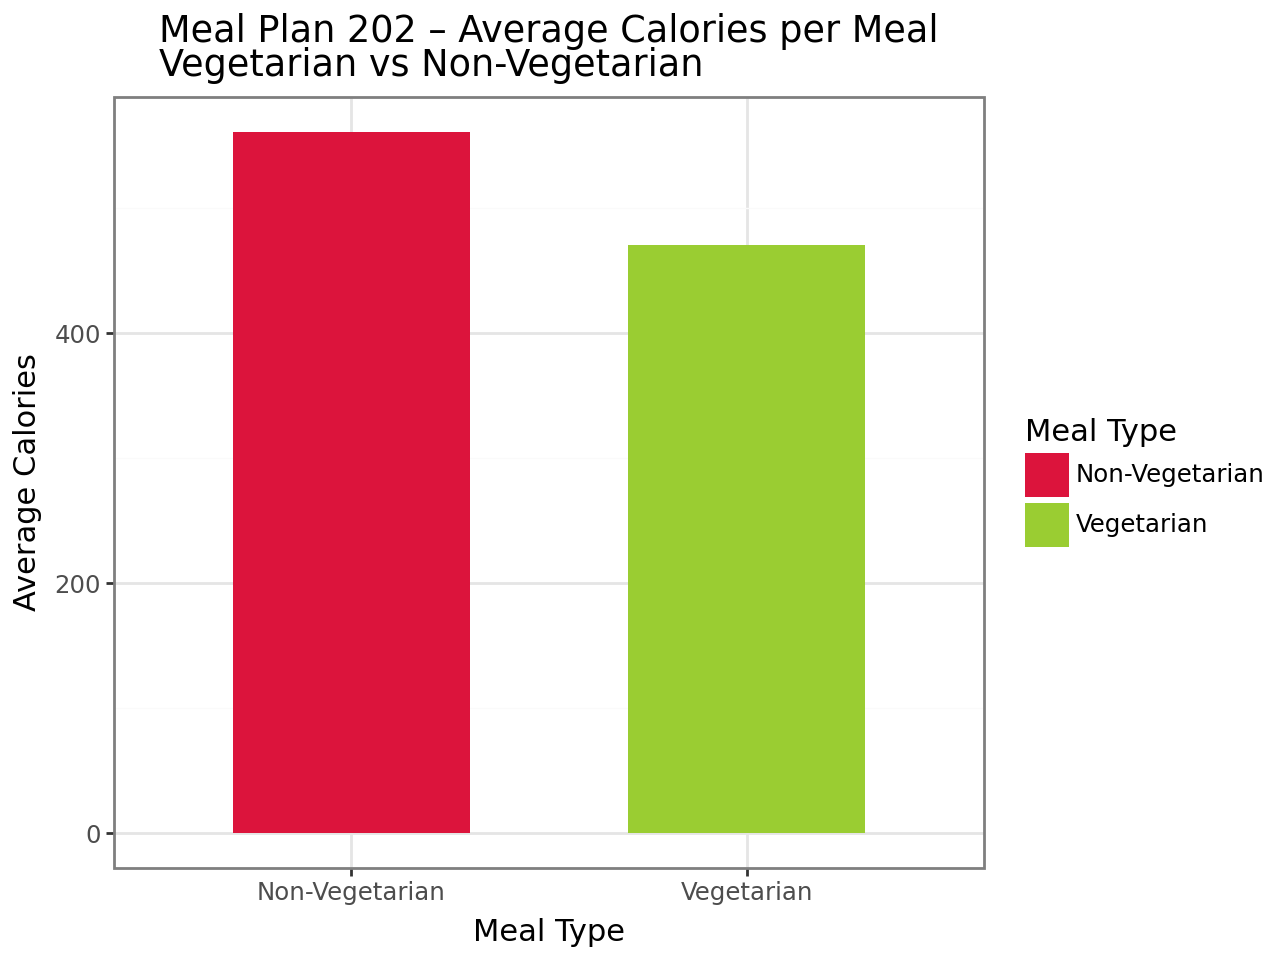

In [208]:
bar_plot= (
    ggplot(df_avg, aes(x="vegetarian", y="Average Calories", fill="vegetarian"))
    + geom_bar(stat="identity", width=0.6)
    + scale_fill_manual(values={"Vegetarian": "yellowgreen",
                                "Non-Vegetarian": "crimson"})
    + labs(
        title="Meal Plan 202 – Average Calories per Meal\nVegetarian vs Non-Vegetarian",
        x="Meal Type",
        y="Average Calories",
        fill="Meal Type"
    )
    + theme_bw()
)
bar_plot
